# TMAE Analysis

Source: https://dadosabertos.aneel.gov.br/dataset/atendimento-ocorrencias-emergenciais

Last Update: 2026/02/17


## Libs:

In [1]:
! pip install --quiet requests 
! pip install --quiet pandas
! pip install --quiet numpy
! pip install --quiet seaborn
! pip install --quiet matplotlib
! pip install --quiet scikit-learn
! pip install --quiet scipy
import requests
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import datetime as dt

## Preparing Enviroment:

In [ ]:
# Config - Df config:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None) 
pd.set_option('display.float_format', '{:.4f}'.format)

In [ ]:
# Config - Image folder:
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)

In [ ]:
# Function - Get data csv:
def get_data_csv(url_csv):
    df = pd.read_csv(url_csv, sep=';', encoding='latin1', decimal=',')
    return df

In [ ]:
# Function - Get data API:
def get_data_api(resource_id):
    offset = 0
    total = []

    while True:
        url = f'https://dadosabertos.aneel.gov.br/api/3/action/datastore_search?resource_id={resource_id}&limit=10000&offset={offset}'
        result = requests.get(url)
        result.raise_for_status()    
        data_json = result.json()
        
        n = data_json['result']['records']

        if not n: 
            break  
        
        total.extend(n)
        offset += 10000
        print(f'Lines collected: {len(total)}')

        # Formação do df:
        df = pd.DataFrame(n)
    return df

In [6]:
# Function - Convert Columns:
def convert_dt_columns(df):
    # Dt Columns:
    columns_dt = [col for col in df.columns if col.upper().startswith('DT')]
    for col in columns_dt:
        df[col] = pd.to_datetime(df[col], errors='coerce')

    # Dat Columns:
    columns_dat = [col for col in df.columns if col.upper().startswith('DAT')]
    for col in columns_dat:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    return df

## Getting Database:

In [7]:
# Principal database:
df = get_data_csv('https://dadosabertos.aneel.gov.br/dataset/dcdff65d-d173-4d2e-a3b9-84eec7702f06/resource/73b00e68-66b1-4a72-8d72-b7baab47048c/download/indicador-atendimento-emergencial.csv')
df.columns = df.columns.str.upper()
df.head()

,DATGERACAOCONJUNTODADOS,SIGAGENTE,NUMCNPJ,IDECONJUNDCONSUMIDORAS,DSCCONJUNDCONSUMIDORAS,SIGINDICADOR,ANOINDICE,NUMPERIODOINDICE,VLRINDICEENVIADO
0,05-02-2026,CPFL-PAULISTA,33050196000188.0000,25.0000,PIRACICABA,NDIACRI,2010,1,10.0000
1,05-02-2026,COELBA,15139629000194.0000,48.0000,MACAUBAS,NDIACRI,2010,1,15.0000
2,05-02-2026,ENEL CE,7047251000170.0000,49.0000,JUATAMA,NDIACRI,2010,1,0.0000
3,05-02-2026,NaN,19527639006601.0000,82.0000,TABULEIRO,NDIACRI,2010,1,3.0000
4,05-02-2026,EMR,19527639000158.0000,82.0000,TABULEIRO,NDIACRI,2010,1,3.0000


In [ ]:
# Helpers - Databases - KPIs:
kpis = 'e3724332-7de8-4273-8f0d-b20ebb91bf7c'
dfKPIs = get_data_api(kpis)
dfKPIs.columns = dfKPIs.columns.str.upper()
dfKPIs.head()

Lines collected: 468


,_ID,DATGERACAOCONJUNTODADOS,SIGINDICADOR,DSCINDICADOR
0,1,2022-08-17T00:00:00,AREA,"Área do conj., expressa em km2, correspondente a área geogr. e não a área elétr."
1,2,2022-08-17T00:00:00,AREAT,Área do conjunto em km2
2,3,2022-08-17T00:00:00,CM,Encargo de uso do sistema de distribuição aplicado à unidade cons. (mensal)
3,4,2022-08-17T00:00:00,CMA,Encargo de uso do sistema de distribuição aplicado à unidade consumidora (anual)
4,5,2022-08-17T00:00:00,CMM,"Consumo médio mensal, em MWh, média aritmética simples do último ano, excluin-"


In [ ]:
# Helpers - Databases - Companies:
companies = '64250fc9-4f7a-4d97-b0d4-3c090e005e1c'
dfComp = get_data_api(companies)
dfComp.columns = dfComp.columns.str.upper()
dfComp.head()

Lines collected: 9736


,_ID,DATGERACAOCONJUNTODADOS,NUMCNPJ,SIGPESSOA,NOMRAZAOSOCIAL,IDCATIVO,IDCCOMERCIALIZACAO,IDCDISTRIBUICAO,IDCGERACAO,IDCTRANSMISSAO
0,1,2026-02-01,04890965000158,None,'' BG NORTE PETROLEO LTDA '',A,0,0,1,0
1,2,2026-02-01,32190231000100,None,2BR COMERCIALIZADORA DE ENERGIA LTDA,A,1,0,0,0
2,3,2026-02-01,03407182000108,None,2MS - ENGENHARIA LTDA,A,0,0,1,0
3,4,2026-02-01,36583766000193,None,2W COMERCIALIZADORA VAREJISTA DE ENERGIA S.A.,A,1,0,0,0
4,5,2026-02-01,08773135000100,None,2W ECOBANK S.A. - EM RECUPERACAO JUDICIAL,A,1,0,0,0


## Exploring Database:

In [10]:
# Database info:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6672090 entries, 0 to 6672089
Data columns (total 9 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   DATGERACAOCONJUNTODADOS  object 
 1   SIGAGENTE                object 
 2   NUMCNPJ                  float64
 3   IDECONJUNDCONSUMIDORAS   float64
 4   DSCCONJUNDCONSUMIDORAS   object 
 5   SIGINDICADOR             object 
 6   ANOINDICE                int64  
 7   NUMPERIODOINDICE         int64  
 8   VLRINDICEENVIADO         float64
dtypes: float64(3), int64(2), object(4)
memory usage: 458.1+ MB


In [11]:
# Removing unnecessary columns:
cols_to_drop = ['DATGERACAOCONJUNTODADOS','NUMCNPJ']
df.drop(columns=cols_to_drop, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6672090 entries, 0 to 6672089
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SIGAGENTE               object 
 1   IDECONJUNDCONSUMIDORAS  float64
 2   DSCCONJUNDCONSUMIDORAS  object 
 3   SIGINDICADOR            object 
 4   ANOINDICE               int64  
 5   NUMPERIODOINDICE        int64  
 6   VLRINDICEENVIADO        float64
dtypes: float64(2), int64(2), object(3)
memory usage: 356.3+ MB


In [12]:
# Database describe:
df.describe()

,IDECONJUNDCONSUMIDORAS,ANOINDICE,NUMPERIODOINDICE,VLRINDICEENVIADO
count,6672053.0000,6672090.0000,6672090.0000,6672090.0000
mean,10643.3344,2010.3956,6.4132,99.7818
std,4171.4301,7.6717,3.4899,297.6341
min,1.0000,2000.0000,1.0000,-7112.4000
25%,7815.0000,2004.0000,3.0000,5.3800
50%,11113.0000,2009.0000,6.0000,40.8100
75%,14158.0000,2017.0000,9.0000,106.8200
max,17419.0000,2026.0000,12.0000,371168.0000


For this analysis, we will focus on the most recent five years of data, which requires filtering out earlier records from the dataset. We will also exclude data from 2026, as it is incomplete (only January is available).

In [13]:
# Removing unnecessary years:
df = df[df['ANOINDICE'] >= 2020]
df = df[df['ANOINDICE'] <= 2025]
df.describe()

,IDECONJUNDCONSUMIDORAS,ANOINDICE,NUMPERIODOINDICE,VLRINDICEENVIADO
count,1184828.0000,1184828.0000,1184828.0000,1184828.0000
mean,14916.1878,2022.5088,6.3339,174.9401
std,1422.5731,1.7104,3.5269,227.0472
min,964.0000,2020.0000,1.0000,0.0000
25%,13753.0000,2021.0000,3.0000,40.8900
50%,14976.0000,2023.0000,6.0000,95.0000
75%,16142.0000,2024.0000,9.0000,234.0000
max,17419.0000,2025.0000,12.0000,78220.4700


Based on the number of records in each column, we can conclude that there are no missing values. Now, let us analyze the meaning of each KPI in the SIGINDICADOR column and select the ones that will be used in this study.

In [17]:
# Merging dataframes: database + kpis:
dfMod = pd.merge(df, dfKPIs, on=['SIGINDICADOR'], how='left')
dfMod.head()

,SIGAGENTE,IDECONJUNDCONSUMIDORAS,DSCCONJUNDCONSUMIDORAS,SIGINDICADOR,ANOINDICE,NUMPERIODOINDICE,VLRINDICEENVIADO,_ID,DATGERACAOCONJUNTODADOS,DSCINDICADOR
0,CPFL JAGUARI,964.0000,PEDREIRA,NDIACRI,2025,1,5.0000,245,2022-08-17T00:00:00,Número de dias críticos verificados no ano
1,CPFL JAGUARI,964.0000,PEDREIRA,NDIACRI,2024,1,5.0000,245,2022-08-17T00:00:00,Número de dias críticos verificados no ano
2,CPFL JAGUARI,964.0000,PEDREIRA,NDIACRI,2021,1,11.0000,245,2022-08-17T00:00:00,Número de dias críticos verificados no ano
3,CPFL JAGUARI,964.0000,PEDREIRA,NDIACRI,2022,1,12.0000,245,2022-08-17T00:00:00,Número de dias críticos verificados no ano
4,CPFL JAGUARI,964.0000,PEDREIRA,NDIACRI,2023,1,12.0000,245,2022-08-17T00:00:00,Número de dias críticos verificados no ano


In [18]:
# Removing unnecessary columns:
cols_to_drop = ['DATGERACAOCONJUNTODADOS','_ID']
dfMod.drop(columns=cols_to_drop, inplace=True)
dfMod.head()

,SIGAGENTE,IDECONJUNDCONSUMIDORAS,DSCCONJUNDCONSUMIDORAS,SIGINDICADOR,ANOINDICE,NUMPERIODOINDICE,VLRINDICEENVIADO,DSCINDICADOR
0,CPFL JAGUARI,964.0000,PEDREIRA,NDIACRI,2025,1,5.0000,Número de dias críticos verificados no ano
1,CPFL JAGUARI,964.0000,PEDREIRA,NDIACRI,2024,1,5.0000,Número de dias críticos verificados no ano
2,CPFL JAGUARI,964.0000,PEDREIRA,NDIACRI,2021,1,11.0000,Número de dias críticos verificados no ano
3,CPFL JAGUARI,964.0000,PEDREIRA,NDIACRI,2022,1,12.0000,Número de dias críticos verificados no ano
4,CPFL JAGUARI,964.0000,PEDREIRA,NDIACRI,2023,1,12.0000,Número de dias críticos verificados no ano


In [22]:
# Analyzing which indicators are present in the SIGINDICADOR column:
dfMod.groupby(['SIGINDICADOR','DSCINDICADOR']).size().reset_index(name='REGISTERS')

,SIGINDICADOR,DSCINDICADOR,REGISTERS
0,NDIACRI,Número de dias críticos verificados no ano,17947
1,Nie,Número de Ocorreências Emergenciais com Interrupções,229783
2,NumOcorr,Número de Ocorrencias Emergenciais no Conjunto no Período,229785
3,TMD,Tempo Médio de Deslocamento,229794
4,TME,Tempo Médio de Execução,229794
5,TMP,Tempo Médio de Preparação,229793
6,VLCLACRI,Valor utilizado no ano para identificar se um dia pode ser classificado critico,17932


Indicators related to Critical Day (NDIACRI and VLCLACRI) will not be part of this study, since our goal is to analyze only emergency service responses. Therefore, rows containing these indicators will be removed.

In [29]:
# Removing unnecessary KPIs:
dfMod.drop(dfMod[dfMod['SIGINDICADOR'].isin(['NDIACRI'])].index, inplace=True)
dfMod.drop(dfMod[dfMod['SIGINDICADOR'].isin(['VLCLACRI'])].index, inplace=True)

# Removing DSCINDICADOR, because we already know the description of the indicators:
dfMod.drop(columns='DSCINDICADOR', inplace=True)

dfMod.head()

,SIGAGENTE,IDECONJUNDCONSUMIDORAS,DSCCONJUNDCONSUMIDORAS,SIGINDICADOR,ANOINDICE,NUMPERIODOINDICE,VLRINDICEENVIADO
35879,CPFL JAGUARI,964.0000,PEDREIRA,TME,2024,10,40.0700
35880,CPFL JAGUARI,964.0000,PEDREIRA,TME,2021,2,66.8600
35881,CPFL JAGUARI,964.0000,PEDREIRA,TME,2020,5,55.3800
35882,CPFL JAGUARI,964.0000,PEDREIRA,TME,2023,12,47.4700
35883,CPFL JAGUARI,964.0000,PEDREIRA,TME,2021,3,36.1900


In [30]:
print('Database info after cleaning:')
dfMod.info()
print('\n Database describe after cleaning:')
dfMod.describe()

Database info after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148949 entries, 35879 to 1184827
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   SIGAGENTE               1133649 non-null  object 
 1   IDECONJUNDCONSUMIDORAS  1148949 non-null  float64
 2   DSCCONJUNDCONSUMIDORAS  1148949 non-null  object 
 3   SIGINDICADOR            1148949 non-null  object 
 4   ANOINDICE               1148949 non-null  int64  
 5   NUMPERIODOINDICE        1148949 non-null  int64  
 6   VLRINDICEENVIADO        1148949 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 61.4+ MB

 Database describe after cleaning:


,IDECONJUNDCONSUMIDORAS,ANOINDICE,NUMPERIODOINDICE,VLRINDICEENVIADO
count,1148949.0000,1148949.0000,1148949.0000,1148949.0000
mean,14916.4839,2022.5074,6.5005,179.9106
std,1422.7862,1.7111,3.4512,228.7718
min,964.0000,2020.0000,1.0000,0.0000
25%,13753.0000,2021.0000,4.0000,43.3800
50%,14976.0000,2023.0000,6.0000,101.0000
75%,16144.0000,2024.0000,9.0000,240.0000
max,17419.0000,2025.0000,12.0000,78220.4700


Now we need to pivot the KPI rows into separate columns, one column per KPI, using VLRINDICEENVIADO as the values.

In [35]:
# Indexes columns for pivot:
idx_cols = [
    'SIGAGENTE',
    'IDECONJUNDCONSUMIDORAS',
    'DSCCONJUNDCONSUMIDORAS',
    'ANOINDICE',
    'NUMPERIODOINDICE',
]

# Pivot table:
newDf = (
    dfMod.pivot_table(
        index=idx_cols,
        columns='SIGINDICADOR',
        values='VLRINDICEENVIADO'
    )
    .reset_index()
)

# Padronize column names:
newDf.columns.name = None
newDf.columns = newDf.columns.str.upper()

# Create a column with TMAE:
newDf['TMAE'] = newDf['TMP'] + newDf['TMD'] + newDf['TME']

newDf.head()

,SIGAGENTE,IDECONJUNDCONSUMIDORAS,DSCCONJUNDCONSUMIDORAS,ANOINDICE,NUMPERIODOINDICE,NIE,NUMOCORR,TMD,TME,TMP,TMAE
0,AME,12581.0000,MÉDIO E BAIXO AMAZONAS,2020,1,580.0000,867.0000,41.4700,54.2500,279.3500,375.0700
1,AME,12581.0000,MÉDIO E BAIXO AMAZONAS,2020,2,746.0000,1096.0000,29.8300,34.8400,430.7400,495.4100
2,AME,12581.0000,MÉDIO E BAIXO AMAZONAS,2020,3,790.0000,1176.0000,27.5900,64.8200,346.6000,439.0100
3,AME,12581.0000,MÉDIO E BAIXO AMAZONAS,2020,4,795.0000,1147.0000,26.7200,49.1200,312.8200,388.6600
4,AME,12581.0000,MÉDIO E BAIXO AMAZONAS,2020,5,1119.0000,1460.0000,29.2000,54.3200,456.3000,539.8200


In [36]:
print('Database info after pivoting:')
newDf.info()
print('\n Database describe after pivoting:')
newDf.describe()

Database info after pivoting:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226607 entries, 0 to 226606
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   SIGAGENTE               226607 non-null  object 
 1   IDECONJUNDCONSUMIDORAS  226607 non-null  float64
 2   DSCCONJUNDCONSUMIDORAS  226607 non-null  object 
 3   ANOINDICE               226607 non-null  int64  
 4   NUMPERIODOINDICE        226607 non-null  int64  
 5   NIE                     226593 non-null  float64
 6   NUMOCORR                226595 non-null  float64
 7   TMD                     226604 non-null  float64
 8   TME                     226604 non-null  float64
 9   TMP                     226603 non-null  float64
 10  TMAE                    226601 non-null  float64
dtypes: float64(7), int64(2), object(2)
memory usage: 19.0+ MB

 Database describe after pivoting:


,IDECONJUNDCONSUMIDORAS,ANOINDICE,NUMPERIODOINDICE,NIE,NUMOCORR,TMD,TME,TMP,TMAE
count,226607.0000,226607.0000,226607.0000,226593.0000,226595.0000,226604.0000,226604.0000,226603.0000,226601.0000
mean,14922.0114,2022.5049,6.5008,172.4953,278.2374,43.8712,69.8816,340.9947,454.7384
std,1424.6510,1.7106,3.4522,163.2278,252.5630,32.0606,190.3088,265.6482,346.8602
min,964.0000,2020.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,13749.0000,2021.0000,4.0000,70.0000,118.0000,28.2300,32.3900,169.2500,251.5600
50%,14986.0000,2023.0000,7.0000,125.0000,210.0000,37.5800,48.5200,276.8800,387.0900
75%,16151.0000,2024.0000,10.0000,221.0000,359.0000,51.4200,78.8300,434.0900,576.0200
max,17419.0000,2025.0000,12.0000,3601.0000,4991.0000,9046.0800,78220.4700,9452.0000,78367.8200


In [43]:
# Checking duplicates:
print('Duplicates:', newDf.duplicated().sum())

Duplicates: 0


In [46]:
# Checking null:
print('Total null values:', newDf.isnull().sum().sum())
print('\nNull values per column:\n', newDf.isnull().sum())
print('\nRows with null values:')
newDf[newDf.isnull().any(axis=1)]

Total null values: 42

Null values per column:
 SIGAGENTE                  0
IDECONJUNDCONSUMIDORAS     0
DSCCONJUNDCONSUMIDORAS     0
ANOINDICE                  0
NUMPERIODOINDICE           0
NIE                       14
NUMOCORR                  12
TMD                        3
TME                        3
TMP                        4
TMAE                       6
dtype: int64

Rows with null values:


,SIGAGENTE,IDECONJUNDCONSUMIDORAS,DSCCONJUNDCONSUMIDORAS,ANOINDICE,NUMPERIODOINDICE,NIE,NUMOCORR,TMD,TME,TMP,TMAE
2533,CEA,14562.0000,SERRA DO NAVIO,2022,8,NaN,NaN,17.7900,49.4300,38.3600,105.5800
2605,CEA,14563.0000,PORTO GRANDE,2022,8,NaN,NaN,21.2200,42.4500,39.1700,102.8400
2677,CEA,14564.0000,TARTARUGALZINHO,2022,8,NaN,NaN,37.1500,64.2200,33.4300,134.8000
2749,CEA,14565.0000,SANTANA,2022,8,NaN,NaN,22.4400,36.7500,84.9900,144.1800
2821,CEA,14566.0000,SANTA RITA,2022,8,NaN,NaN,14.6100,27.6300,106.0900,148.3300
2893,CEA,14567.0000,PORTUARIA,2022,8,NaN,NaN,20.5900,45.0400,103.1100,168.7400
2965,CEA,14568.0000,OIAPOQUE,2022,8,NaN,NaN,16.7500,27.9400,22.6700,67.3600
3037,CEA,14569.0000,MACAPA II,2022,8,NaN,NaN,16.9800,27.2100,103.4500,147.6400
3109,CEA,14570.0000,AMAPA,2022,8,NaN,NaN,14.6700,18.2000,22.1500,55.0200
3181,CEA,14571.0000,CALÇOENE,2022,8,NaN,NaN,20.0300,50.9800,26.9200,97.9300


In [47]:
# Removing rows with null values:
newDf.dropna(inplace=True)

# Checking null:
print('Total null values:', newDf.isnull().sum().sum())
print('\nRows with null values:')
newDf[newDf.isnull().any(axis=1)]

Total null values: 0

Rows with null values:


,SIGAGENTE,IDECONJUNDCONSUMIDORAS,DSCCONJUNDCONSUMIDORAS,ANOINDICE,NUMPERIODOINDICE,NIE,NUMOCORR,TMD,TME,TMP,TMAE


## Data Analysis:

At this stage of the analysis, we focus on companies instead of conjuntos (subgroups of companies). Therefore, all KPIs will be aggregated at the company level.

Next, we perform a graphical analysis of the variables.

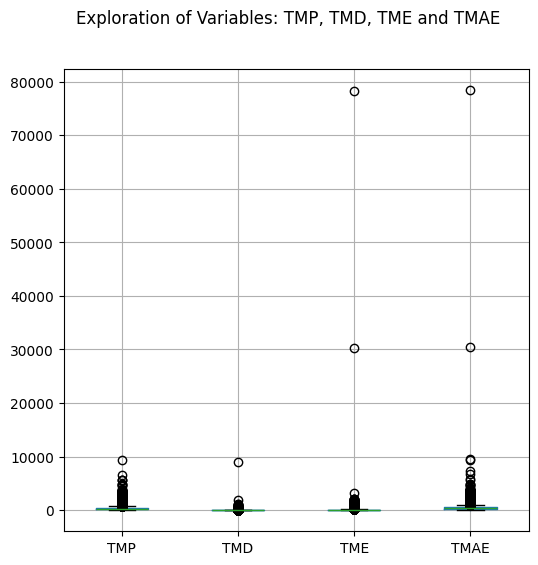

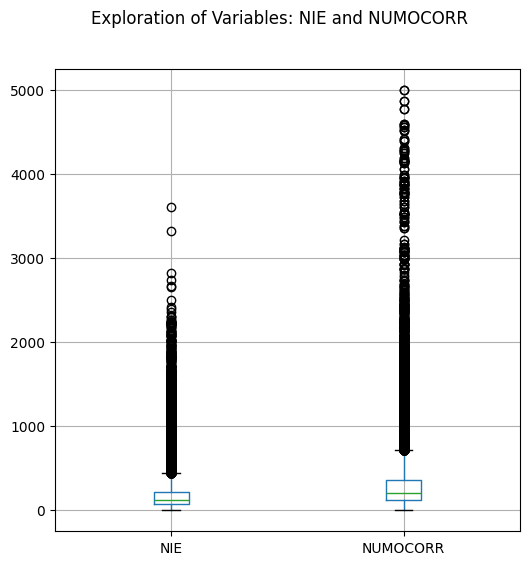

In [49]:
fig = plt.figure()
fig.suptitle('Exploration of Variables: TMP, TMD, TME and TMAE')
fig.set_size_inches(6,6)
ax = fig.add_subplot(111)
newDf.boxplot(column=['TMP','TMD','TME','TMAE'])
#plt.savefig(os.path.join(IMAGES_PATH, 'Exploracao_DF_Idade_Ano.eps'))
plt.show()

fig = plt.figure()
fig.suptitle('Exploration of Variables: NIE and NUMOCORR')
fig.set_size_inches(6,6)
ax = fig.add_subplot(111)
newDf.boxplot(column=['NIE', 'NUMOCORR'])
#plt.savefig(os.path.join(IMAGES_PATH, 'Exploracao_DF_Nodulos.eps'))
plt.show()